## 1. About Author

- `Name`: Ahmad Mubarak
- `Code Submission Date`: 
- `Project`: Orange Disease Detection
- `Authors Contact info`:
  - [Email](ahmadmubarak01@gmail.com)
  - [LinkedIn](https://www.linkedin.com/in/ahmad-mubarak-19861a177/)
  - [Github](https://github.com/Ahmad1998-RPA)

## 1.1 Meta Data (About the Data)

- `Data`: Orange Fruit Daatset
- `Dataset`: [link](https://www.kaggle.com/datasets/mohammedarfathr/orange-fruit-daatset/data)
- `Description`: The Data set was downloaded from kaggle for ML practice.

## 1.2 Kernel Version Used.

- `Python 3.10.2`

## 1.3 Installed Libraries
- `numpy` `matplotlib`  `torch` `torchvision` `tqdm`

## 2. Import libraries

In [19]:
import os
import cv2
import copy
import time
import random
import torch
import torchvision
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import seaborn as sns
from PIL import Image
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.models as models
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay


## 3. Load DataSet

In [11]:
# Load the dataset
train_dir = 'E:/DataScience/OrangeDiseaseDetection/Field Data/Train/'
test_dir = 'E:/DataScience/OrangeDiseaseDetection/Field Data/Test/'

## 4. Visualize 5 Images per Category

Class names: ['citrus canker', 'healthy', 'melanose']


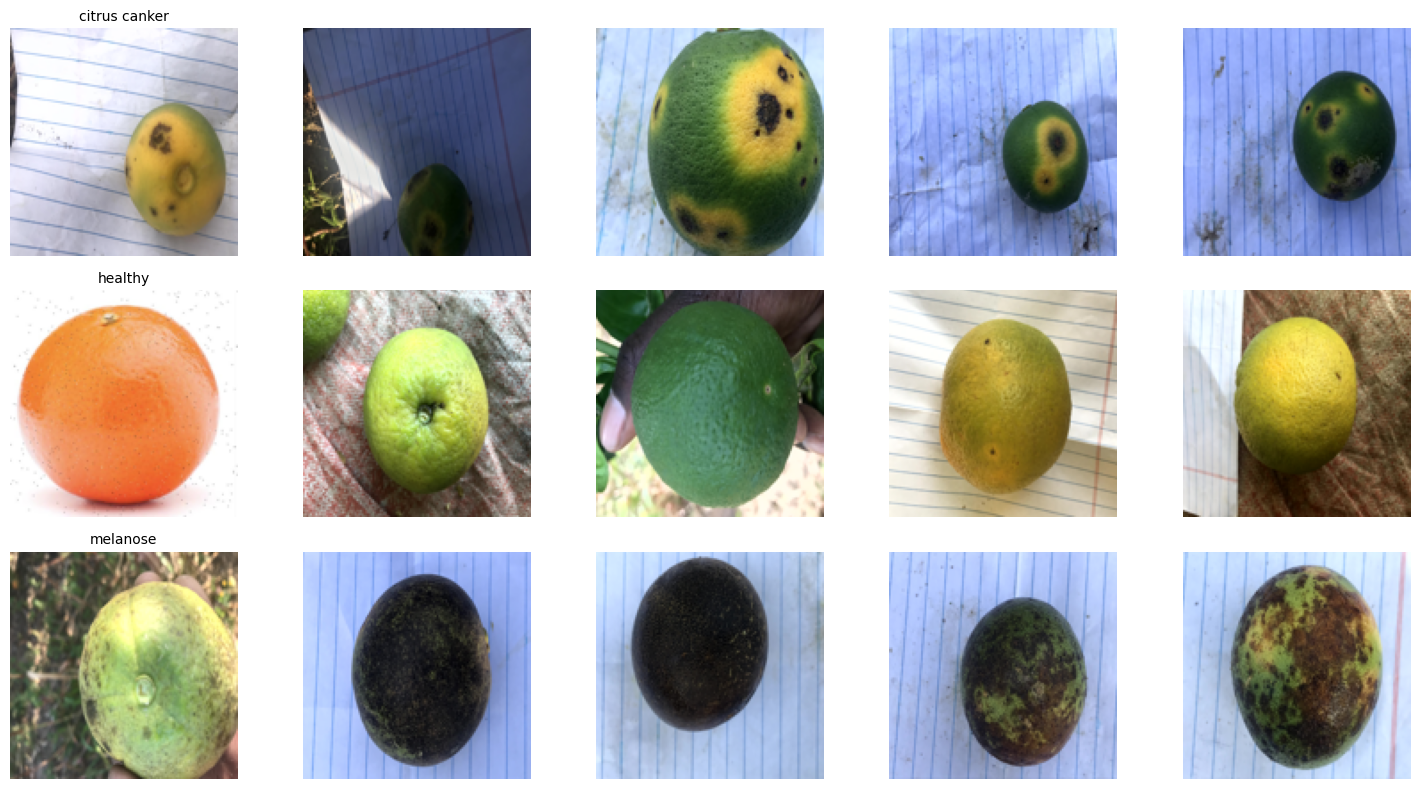

In [12]:
# Image transformations
transform = Compose([Resize((128, 128)),ToTensor()])

# Load datasets
train_dataset = ImageFolder(root=train_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Class names (folder names)
class_names = train_dataset.classes
print(f"Class names: {class_names}")

# Create a mapping: class index -> image paths
class_to_img_paths = {cls: [] for cls in class_names}
for img_path, label in train_dataset.samples:
    class_to_img_paths[class_names[label]].append(img_path)

# Plot 5 random images per class
fig, axes = plt.subplots(len(class_names), 5, figsize=(15, 8))
for row_idx, cls in enumerate(class_names):
    selected_imgs = random.sample(class_to_img_paths[cls], 5)
    for col_idx, img_path in enumerate(selected_imgs):
        image = Image.open(img_path).resize((128, 128))
        axes[row_idx, col_idx].imshow(image)
        axes[row_idx, col_idx].axis('off')
        if col_idx == 0:
            axes[row_idx, col_idx].set_title(cls, fontsize=10)

plt.tight_layout()
plt.show()


In [13]:
# Load pretrained EfficientNet_B0
model = models.efficientnet_b0(pretrained=True)

# Freeze all feature extractor layers
for param in model.features.parameters():
    param.requires_grad = False

# Modify the classifier head to match 3 output classes
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 3)  # 3 classes: canker, healthy, melanose

# Move model to device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print("Model ready, using device:", device)


Model ready, using device: cpu


In [14]:
# Freeze all layers in the model
for param in model.parameters():
    param.requires_grad = False

# Unfreeze only the final classification head
# EfficientNet_B0 has classifier[1] as the final linear layer
# Replace it with a new one for 3 classes
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 3)

# Ensure the new classifier layer is trainable
for param in model.classifier[1].parameters():
    param.requires_grad = True

# Move model to device again (if needed)
model = model.to(device)

print("✅ Model is now ready with frozen base and new trainable classification head.")


✅ Model is now ready with frozen base and new trainable classification head.


## Step 5: Data Augmentation & Normalization

In [15]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

# Transformation for training images
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Transformation for test images (no augmentation, just resizing & normalization)
test_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = ImageFolder(root=train_dir, transform=train_transforms)
test_dataset = ImageFolder(root=test_dir, transform=test_transforms)


## Step 6: Define Loss, Optimizer, and Metrics

In [16]:
# Define loss function
criterion = nn.CrossEntropyLoss()

# Optimizer (Adam or SGD)
optimizer = optim.Adam(model.parameters(), lr=0.001)
# OR use this instead if you prefer SGD
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [17]:
def calculate_metrics(y_true, y_pred):
    accuracy  = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall    = recall_score(y_true, y_pred, average='macro')
    f1        = f1_score(y_true, y_pred, average='macro')
    
    return accuracy, precision, recall, f1


## Step 7: Training Loop with Early Stopping & Scheduler

In [18]:
# Learning Rate Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Early stopping parameters
patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_wts = copy.deepcopy(model.state_dict())

# Track metrics
train_loss_history, val_loss_history = [], []
train_acc_history, val_acc_history = [], []

num_epochs = 10  # You can set 10–25

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 30)

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
            dataloader = train_loader
        else:
            model.eval()
            dataloader = test_loader

        running_loss = 0.0
        running_corrects = 0
        all_preds = []
        all_labels = []

        for inputs, labels in tqdm(dataloader, desc=f"{phase.title()} Phase"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = running_corrects.double() / len(dataloader.dataset)
        accuracy, precision, recall, f1 = calculate_metrics(all_labels, all_preds)

        if phase == 'train':
            train_loss_history.append(epoch_loss)
            train_acc_history.append(epoch_acc.item())
            scheduler.step()
        else:
            val_loss_history.append(epoch_loss)
            val_acc_history.append(epoch_acc.item())

            # Early stopping
            if epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= patience:
                print(f"\n⏹️ Early stopping triggered at epoch {epoch+1}")
                model.load_state_dict(best_model_wts)
                break

        print(f"{phase.title()} Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")

    else:
        continue
    break  # Break outer loop if early stopping is triggered



Epoch 1/10
------------------------------


Train Phase: 100%|██████████| 215/215 [25:10<00:00,  7.02s/it]


Train Loss: 0.3355 | Acc: 0.8895 | Precision: 0.8908 | Recall: 0.8879 | F1: 0.8890


Val Phase: 100%|██████████| 54/54 [08:35<00:00,  9.54s/it]


Val Loss: 0.1797 | Acc: 0.9442 | Precision: 0.9450 | Recall: 0.9435 | F1: 0.9440

Epoch 2/10
------------------------------


Train Phase: 100%|██████████| 215/215 [34:29<00:00,  9.63s/it]


Train Loss: 0.2242 | Acc: 0.9214 | Precision: 0.9214 | Recall: 0.9209 | F1: 0.9211


Val Phase: 100%|██████████| 54/54 [08:36<00:00,  9.56s/it]


Val Loss: 0.1606 | Acc: 0.9494 | Precision: 0.9503 | Recall: 0.9487 | F1: 0.9491

Epoch 3/10
------------------------------


Train Phase: 100%|██████████| 215/215 [31:51<00:00,  8.89s/it]


Train Loss: 0.1919 | Acc: 0.9343 | Precision: 0.9343 | Recall: 0.9339 | F1: 0.9341


Val Phase: 100%|██████████| 54/54 [05:34<00:00,  6.20s/it]


Val Loss: 0.1458 | Acc: 0.9581 | Precision: 0.9583 | Recall: 0.9577 | F1: 0.9579

Epoch 4/10
------------------------------


Train Phase: 100%|██████████| 215/215 [22:07<00:00,  6.17s/it]


Train Loss: 0.1873 | Acc: 0.9314 | Precision: 0.9319 | Recall: 0.9310 | F1: 0.9314


Val Phase: 100%|██████████| 54/54 [05:30<00:00,  6.11s/it]


Val Loss: 0.1466 | Acc: 0.9547 | Precision: 0.9549 | Recall: 0.9544 | F1: 0.9545

Epoch 5/10
------------------------------


Train Phase: 100%|██████████| 215/215 [32:30<00:00,  9.07s/it]


Train Loss: 0.1817 | Acc: 0.9339 | Precision: 0.9337 | Recall: 0.9335 | F1: 0.9336


Val Phase: 100%|██████████| 54/54 [08:20<00:00,  9.27s/it]


Val Loss: 0.1368 | Acc: 0.9570 | Precision: 0.9571 | Recall: 0.9567 | F1: 0.9567

Epoch 6/10
------------------------------


Train Phase: 100%|██████████| 215/215 [26:36<00:00,  7.43s/it]


Train Loss: 0.1675 | Acc: 0.9382 | Precision: 0.9380 | Recall: 0.9381 | F1: 0.9380


Val Phase: 100%|██████████| 54/54 [03:59<00:00,  4.44s/it]


Val Loss: 0.1357 | Acc: 0.9599 | Precision: 0.9596 | Recall: 0.9598 | F1: 0.9596

Epoch 7/10
------------------------------


Train Phase: 100%|██████████| 215/215 [16:12<00:00,  4.53s/it]


Train Loss: 0.1721 | Acc: 0.9387 | Precision: 0.9385 | Recall: 0.9384 | F1: 0.9384


Val Phase: 100%|██████████| 54/54 [04:35<00:00,  5.11s/it]


Val Loss: 0.1345 | Acc: 0.9610 | Precision: 0.9609 | Recall: 0.9608 | F1: 0.9608

Epoch 8/10
------------------------------


Train Phase: 100%|██████████| 215/215 [20:08<00:00,  5.62s/it]


Train Loss: 0.1798 | Acc: 0.9363 | Precision: 0.9364 | Recall: 0.9363 | F1: 0.9363


Val Phase: 100%|██████████| 54/54 [05:00<00:00,  5.57s/it]


Val Loss: 0.1485 | Acc: 0.9512 | Precision: 0.9508 | Recall: 0.9520 | F1: 0.9508

Epoch 9/10
------------------------------


Train Phase: 100%|██████████| 215/215 [20:06<00:00,  5.61s/it]


Train Loss: 0.1683 | Acc: 0.9368 | Precision: 0.9369 | Recall: 0.9367 | F1: 0.9368


Val Phase: 100%|██████████| 54/54 [04:59<00:00,  5.55s/it]


Val Loss: 0.1340 | Acc: 0.9628 | Precision: 0.9627 | Recall: 0.9627 | F1: 0.9627

Epoch 10/10
------------------------------


Train Phase: 100%|██████████| 215/215 [20:01<00:00,  5.59s/it]


Train Loss: 0.1650 | Acc: 0.9406 | Precision: 0.9407 | Recall: 0.9401 | F1: 0.9403


Val Phase: 100%|██████████| 54/54 [05:00<00:00,  5.56s/it]

Val Loss: 0.1367 | Acc: 0.9599 | Precision: 0.9602 | Recall: 0.9594 | F1: 0.9596


## Step 8: Evaluate the Model
🧪 What We’ll Do:
- Predict on the test set
- Show a confusion matrix
- Print a classification report (Precision, Recall, F1-score)
- Plot some misclassified images (optional but insightful)

#### 8.1 Evaluation

In [20]:
# Put model in eval mode
model.eval()

all_preds = []
all_labels = []
all_images = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_images.extend(inputs.cpu())  # Keep for visualization


### 8.2 Confusion Matrix

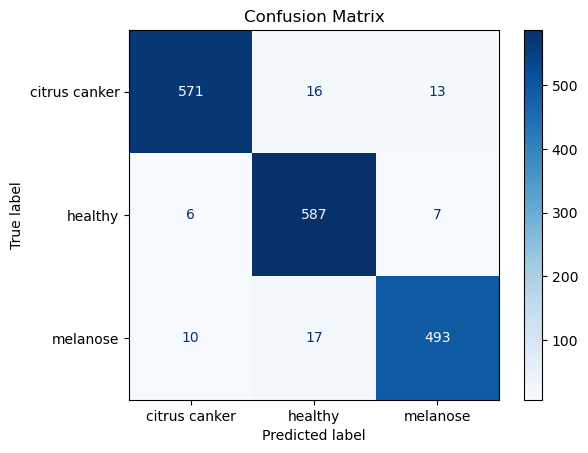

In [21]:
# Class names (read from ImageFolder)
class_names = test_dataset.classes

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

### 8.3 Classification report

In [22]:
# Classification report
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))


Classification Report:

               precision    recall  f1-score   support

citrus canker       0.97      0.95      0.96       600
      healthy       0.95      0.98      0.96       600
     melanose       0.96      0.95      0.95       520

     accuracy                           0.96      1720
    macro avg       0.96      0.96      0.96      1720
 weighted avg       0.96      0.96      0.96      1720



## Save the model

In [24]:
# Save the best model weights
model_path = "Models/orange_disease_classifier.pth"
torch.save(best_model_wts, model_path)
print(f"✅ Model saved to: {model_path}")


✅ Model saved to: Models/orange_disease_classifier.pth


## 📤 Load Model for Inference

In [25]:
# Re-load EfficientNet and re-attach the classification head
from torchvision import models

model = models.efficientnet_b0(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

# Replace the classifier head
num_classes = 3
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

# Load weights
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()

print("✅ Model loaded and ready for inference")


c:\Users\Ahmad\anaconda3\envs\OrangeDisease\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Ahmad\anaconda3\envs\OrangeDisease\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ Model loaded and ready for inference


In [26]:
from torchvision import transforms
from PIL import Image

# Define transform (same as test transforms)
inference_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

def predict_image(img_path, model, class_names):
    image = Image.open(img_path).convert("RGB")
    input_tensor = inference_transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        _, pred = torch.max(output, 1)

    predicted_class = class_names[pred.item()]
    return predicted_class


In [ ]:
img_path = "E:/DataScience/OrangeDiseaseDetection/Field Data/Test/healthy/h (582).jpg"
# "E:\DataScience\OrangeDiseaseDetection\Field Data\Test\healthy\h (582).jpg"
prediction = predict_image(img_path, model, class_names)
print(f"🔍 Predicted Class: {prediction}")

🔍 Predicted Class: healthy


In [ ]:
img_path = "E:/DataScience/OrangeDiseaseDetection/Field Data/Test/healthy/h (95).jpg"
prediction = predict_image(img_path, model, class_names)
print(f"🔍 Predicted Class: {prediction}")

🔍 Predicted Class: citrus canker


In [ ]:
img_path = "E:/DataScience/OrangeDiseaseDetection/Field Data/Test/melanose/m (138).jpg"
prediction = predict_image(img_path, model, class_names)
print(f"🔍 Predicted Class: {prediction}")

🔍 Predicted Class: healthy


In [35]:
img_path = "E:/DataScience/OrangeDiseaseDetection/Field Data/Test/citrus canker/c (2655).jpg"
prediction = predict_image(img_path, model, class_names)
print(f"🔍 Predicted Class: {prediction}")

🔍 Predicted Class: citrus canker
